<a href="https://colab.research.google.com/github/TALeonard/19ma573thomasleonard/blob/master/src/hw7_vasicek_calibration_v02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part 1: Verify the solution.

Verify the explicit form of $r_{t}$ given by

$$r_{t} = r_{0}e^{-\kappa t} + \mu(1 - e^{-\kappa t}) + \sigma e^{-\kappa t}\int_{0}^{t}e^{\kappa s} dW_{s}$$

is the solution to the original Vasicek model, that being

$$dr_{t} = \kappa(\mu - r_{t})dt + \sigma dW_{t},$$

Given a Vasicek model with parameter $\theta = (\kappa, \mu, \sigma, r_{0})$.

Consider $dr_{t}$ as a differential equation. Isolate all $r_{t}$ terms on one side.

$$dr_{t} + \kappa r_{t} dt = \kappa \mu dt + \sigma dW_{t}$$

With respect to $dr_{t}$ this is now a standard integrating factor problem. Identify the integrating factor as 

$$e^{\int \kappa dt} = e^{\kappa t}$$

Multiply both sides by the integrating factor and condense left-hand side as is "standard" in this type of problem:

$$\rightarrow e^{\kappa t} (dr_{t} + \kappa r_{t} dt) = e^{\kappa t} (\kappa \mu dt + \sigma dW_{t})$$

$$\rightarrow d(e^{\kappa t}r_{t}) =  e^{\kappa t}\kappa \mu dt +  e^{\kappa t} \sigma dW_{t}$$

Integrate both sides, swapping any and all instances of $t$ on the right hand side for a dummy variable $s$:

$$\rightarrow \int_{0}^{t}d(e^{\kappa t}r_{t}) =  \int_{0}^{t}e^{\kappa s}\kappa \mu ds +  \int_{0}^{t}e^{\kappa s} \sigma dW_{s}$$

For the left-hand side, note that

$$\int_{0}^{t}d(e^{\kappa t}r_{t}) =  [e^{\kappa t}r_{t}]_{0}^{t} = e^{\kappa t}r_{t} - r_{0}$$

So we have

$$\rightarrow e^{\kappa t}r_{t} = r_{0} +  \int_{0}^{t}e^{\kappa s}\kappa \mu ds +  \int_{0}^{t}e^{\kappa s} \sigma dW_{s}$$

All that remains is to evaluate the first of the 2 remaining integrals and divide both sides by $e^{\kappa t}$. First, consider the integral

$$\int_{0}^{t}e^{\kappa s}\kappa \mu ds = \kappa \mu \int_{0}^{t}e^{\kappa s} = \kappa \mu [e^{\kappa s}\frac{1}{\kappa}]_{0}^{t} =  \kappa \mu \frac{1}{\kappa}[e^{\kappa t} - 1]$$

$$=\mu (e^{\kappa t} - 1)$$

Substitute this into the equation:

$$\rightarrow  e^{\kappa t}r_{t} = r_{0} +  \mu (e^{\kappa t} - 1) +  \int_{0}^{t}e^{\kappa s} \sigma dW_{s}$$

Multiply both sides by $e^{-\kappa t}$ and simplify to find our result:

$$r_{t} = e^{-\kappa t}r_{0} +  e^{-\kappa t}\mu (e^{\kappa t} - 1) +  e^{-\kappa t}\int_{0}^{t}e^{\kappa s} \sigma dW_{s}$$

$$=r_{0}e^{-\kappa t} +  \mu (1 - e^{-\kappa t}) +  \sigma e^{-\kappa t}\int_{0}^{t}e^{\kappa s}  dW_{s}$$

Which shows that the given equation of $r_{t}$ is a solution to the original Vasicek model. $\square$

#Part 2: Design pricing engine of ZCB P(0,T) using the explicit formula. 

First, import modules.

In [0]:
import numpy as np
import scipy.stats as ss
import scipy.optimize as so
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
def zcb_price_explicit(T,kappa,mu,sigma,r0):
  #Compute B(0,T).
  B = (1 - np.exp(-1 * kappa * T))/kappa
  
  #Now, compute A(0,T).
  A = ((mu - ((sigma**2)/(2*(kappa**2)))) * (B - T)) - (((sigma**2)/(4*kappa))*(B**2))
  
  #Given these, compute A - B*r0.
  diff = A - (B * r0)
  
  #Price is the exp(diff).
  return np.exp(diff)

In [0]:
theta = [0.1, 0.05, 0.003, 0.03]
kappa, mu, sigma, r0 = theta

#Part 3: Design alternative engine to price ZCB P(0,T) using exact sampling.

The integral inside the expectation follows a normal distribution with

$$\mu_{r} = \mu T + (r_{0} - \mu)\frac{1-e^{-\kappa T}}{\kappa}$$

$$\sigma^{2}_{r} = \frac{\sigma^{2}}{2\kappa^{3}}(2\kappa T - 3 + 4e^{-\kappa T} - e^{-2 \kappa T})$$

Use this information to produce random samples of a related normal RV and find the samples' average to approximate the expected value by.

In [0]:
def zcb_price_exact_sample(T,kappa,mu,sigma,r0,num_path):
  #First, compute the mean and variance of the exponent.
  mu_r = (mu*T) + ((r0 - mu)*(1-np.exp(-1*kappa*T))/kappa)
  var_r = ((sigma**2)/(2*(kappa**3)))*((2*kappa*T) - 3 + (4*np.exp(-1*kappa*T)) - np.exp(-2*kappa*T))
  
  #With this, we can compute (num_path) many iterations of the integral.
  #Generate random values for R, the random variable at hand.
  r = np.random.normal(mu_r,var_r,num_path)
  
  #Create "realized" values for e^(-R(T))
  r_output = np.exp(-1 * r)
  
  #Return the mean of the realized values.
  return r_output.mean()

#Part 4: Compute ZCB P(0,1) and Libor L(0,1) using the parameters outlined in the assignment.

Method is to be done through both engines. No number of paths is given, so I will use 1000.

In [0]:
'''=======paras======='''
theta = [.1, .05, .003, .03]
kappa, mu, sigma, r0 = theta
num_path = 1000

In [0]:
formula_price = zcb_price_explicit(1,kappa,mu,sigma,r0)
sample_price = zcb_price_exact_sample(1,kappa,mu,sigma,r0,num_path)

print("ZCB P(0,1) price by formula is " + str(formula_price))
print("ZCB P(0,1) price by exact sampling is " + str(sample_price))

ZCB P(0,1) price by formula is 0.9695084475425054
ZCB P(0,1) price by exact sampling is 0.9695071141420967


In [0]:
# Use above values to compute LIBOR L(0,1) values.
# L(t,T) = (100/(T-t)) * ((1/P(t,T)) - 1)

def libor_price(T,P):
  #WARNING: THIS ASSUMES STARTING TIME IS 0, I.E. L(0,T).
  #P is price of relevant ZCB.
  factor_1 = 100/(T)
  factor_2 = (1/P) - 1
  return factor_1 * factor_2

print("LIBOR L(0,1) price using ZCB formula price is " + str(libor_price(1,formula_price)))
print("LIBOR L(0,1) price using ZCB sample price is " + str(libor_price(1,sample_price)))

LIBOR L(0,1) price using ZCB formula price is 3.145052787810565
LIBOR L(0,1) price using ZCB sample price is 3.145194647167293


#Part 5: Price 10-term swap rates with term length 1/2 year.

This translates to finding the price of $s(t = 0, T = 5, N = 10)$.

This is just a simple computation. Define swap rate pricing engine, and produce results via both engines.

In [0]:
def swap_price_explicit(T,N,kappa,mu,sigma,r0):
  #WARNING: THIS ASSUMES STARTING TIME IS 0, I.E. L(0,T).
  #Define delta.
  delta = T/N
  
  #Create array to store P(t,t+j*delta) terms.
  price_explicit = np.zeros(N)
  
  #Iteratively fill price matrix.
  for j in range(N):
    price_explicit[j] = zcb_price_explicit((j+1)*delta,kappa,mu,sigma,r0)
  
  #Produce numerator and denominator.
  num_explicit = 1 - price_explicit[N-1]
  denom_explicit = price_explicit.sum()
  
  s_explicit = 100 * num_explicit / denom_explicit
  
  return s_explicit
  
  
def swap_price_sample(T,N,kappa,mu,sigma,r0,num_path):
  #WARNING: THIS ASSUMES STARTING TIME IS 0, I.E. L(0,T).
  #Define delta.
  delta = T/N
  
  #Create array to store P(t,t+j*delta) terms.
  price_sample = np.zeros(N)
  
  #Iteratively fill price matrix.
  for j in range(N):
    price_sample[j] = zcb_price_exact_sample((j+1)*delta,kappa,mu,sigma,r0,num_path)
  
  #Produce numerator and denominator.
  num_sample = 1 - price_sample[N-1]
  denom_sample = price_sample.sum()
  
  s_sample = 100 * num_sample / denom_sample

  return s_sample

In [0]:
#Now, compute.

s_explicit = swap_price_explicit(5,10,kappa,mu,sigma,r0)
s_sample = swap_price_sample(5,10,kappa,mu,sigma,r0,num_path)

print("10-term swap rate with term length 1/2 year using the formula is " + str(s_explicit))
print("10-term swap rate with term length 1/2 year using exact sampling is " + str(s_sample))

10-term swap rate with term length 1/2 year using the formula is 1.7209106981949385
10-term swap rate with term length 1/2 year using exact sampling is 1.7222227212103356


# Part 6: LIBOR Calibration of Vasicek [Consider revising calibration technique]

Given the supplied data, we want to calibrate the Vasicek model. 5 Data points to find 4 unknowns: $\kappa$, $\mu$, $\sigma$, and $r_{0}$. I will opt to use SSRE, as the assignment references.

The idea broadly speaking will be this:

1. Use the given LIBOR rates for one time period to find related ZCB P(0,T) rates.

2. Given said rates, use code to calculate "ideal" combination of the 4 unknowns (found through SSRE)

3. Given said combination, re-calculate the ZCB price for each time period and use this to find the respective LIBOR rate.

4. Plot against the true values of the LIBOR rate.

First, import data. Will use the dataset the professor provided.

In [0]:
dfLiborRate = pd.DataFrame({'maturity (months)': [1, 2, 3, 6, 12],
                           '20081029 rate(%)': [3.1175, 3.2738, 3.4200, 3.4275, 3.4213],
                           '20110214 rate(%)': [0.2647, 0.2890, 0.3140, 0.4657, 0.7975]
                           })

libor_2008_10_29 = [3.1175, 3.2738, 3.4200, 3.4275, 3.4213];
libor_maturities = [1/12, 2/12, 3/12, 6/12, 12/12]

Now, define an error function to use. I will use the SSRE function from the BSM Calibration segment of the lucture, i.e. the distance funciton

$$H(x,y) = (\sum_{i = 1}^{n}w_{i}|\frac{x_{i}-y_{i}}{y_{i}}|^{p})^{1/p}$$

With $w_{i} = 1$ and $p = 2$.

Define the error function above and the LIBOR calibration.

In [0]:
def vasicek_libor_error_function(theta, market_rates, maturities):
  err1 = 0
  kappa, mu, sigma, r0 = theta
  
  for i in np.arange(len(market_rates)):
    # Use Theta input to compute ZCB price for maturity i.
    P = zcb_price_explicit(maturities[i],kappa,mu,sigma,r0)
    
    # Use calculated ZCB price to compute LIBOR rate.
    calc_libor = libor_price(maturities[i],P)
    
    # Increment error based on estimated LIBOR.
    err1 = err1 + ((calc_libor - market_rates[i])/market_rates[i])**2
  return err1

def libor_calibration(libor_rates,maturities):
  # Supply initial guess. Use theta array from assignment as baseline.
  init_theta = np.array([0.1, 0.05, 0.003, 0.03])
  init_kappa, init_mu, init_sigma, init_r0 = init_theta
  return so.fmin(vasicek_libor_error_function, init_theta, args = (libor_rates, maturities), disp = 0)

Now, run this calibration using the above LIBOR rates.

In [0]:
calibrated_theta = libor_calibration(libor_2008_10_29,libor_maturities)

print(">>>Calibrated kappa is " + str(calibrated_theta[0]))
print(">>>Calibrated mu is " + str(calibrated_theta[1]))
print(">>>Calibrated sigma is " + str(calibrated_theta[2]))
print(">>>Calibrated r_0 is " + str(calibrated_theta[3]))

>>>Calibrated kappa is 561.3428170454375
>>>Calibrated mu is 0.03450520336111293
>>>Calibrated sigma is -8.180249459633814
>>>Calibrated r_0 is -0.11360832553532021


I don't know what the constraints on the elements in the vasicek model usually are, but something tells me this isn't right. Check the price of a bond with T = 1.

In [0]:
c_kappa = calibrated_theta[0]
c_mu = calibrated_theta[1]
c_sigma = calibrated_theta[2]
c_r0 = calibrated_theta[3]

bond = zcb_price_explicit(1,c_kappa,c_mu,c_sigma,c_r0)

print('>>>Bond Price is ' + str(bond))

>>>Bond Price is 0.9664405910470621


The bond price seems reasonable enough at least. I'm still concerned about my choice of calibration and will likely need to use a different scipy.optimize algorithm which has constraints (i.e. forcing my arguments to be positive). Until then, plot calibration LIBOR rates against true LIBOR rates:

Text(0, 0.5, 'True LIBOR rate')

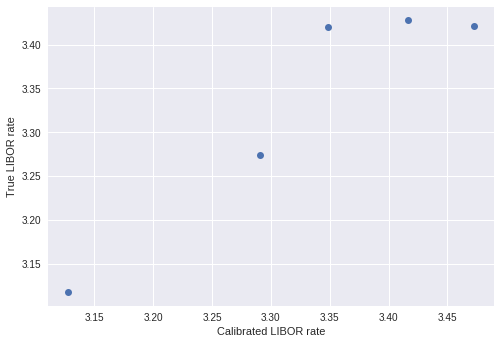

In [0]:
x_var = np.zeros(len(libor_2008_10_29))

for i in range(len(x_var)):
  c_bond_price = zcb_price_explicit(libor_maturities[i],c_kappa,c_mu,c_sigma,c_r0)
  x_var[i] = libor_price(libor_maturities[i],c_bond_price)

plt.plot(x_var,libor_2008_10_29,'o')
plt.xlabel('Calibrated LIBOR rate')
plt.ylabel('True LIBOR rate')

This reinforces my concerns.

# Part 7: Swap Calibration of Vasicek [Consider revising calibration technique]

Given the supplied data, we want to calibrate the Vasicek model. We again wish to find values for the 4 unknowns: $\kappa$, $\mu$, $\sigma$, and $r_{0}$. I will again opt to use SSRE. The term length for these data points is $\frac{1}{2}$ a year, i.e. for the 2-year swap we'd consider $s(t=0,T=2,N=4)$.

The idea broadly speaking will be this:

1. Use the given swap rates for one time period to find a set of "ideal" unknowns. This will be a touch more difficult since we now have multiple ZCB P(0,T) rates to work with (the first term alone will have 4 separate ZCB rates).

2. Given said combination, re-calculate the ZCB price for each time period and use this to find the respective swap rates.
1
3. Plot against the true values of the swap rates.

In [0]:
dfSwapRate = pd.DataFrame({'term (year)': [2, 3, 5, 7, 10, 15, 30],
                          '20081029 rate(%)': [2.6967, 3.1557, 3.8111, 4.1497, 4.3638, 4.3753, 4.2772],
                          '20110214 rate(%)': [1.0481, 1.5577, 2.5569, 3.1850, 3.7225, 4.1683, 4.4407]
                          })

swap_2008_10_29 = [2.6967, 3.1557, 3.8111, 4.1497, 4.3638, 4.3753, 4.2772]
swap_2011_02_14 = [1.0481, 1.5577, 2.5569, 3.1850, 3.7225, 4.1683, 4.4407]
swap_maturities = [2, 3, 5, 7, 10, 15, 30]
swap_terms = [4, 6, 10, 14, 20, 30, 60]

In [0]:
def vasicek_swap_error_function(theta, market_rates, maturities, terms):
  err1 = 0
  kappa, mu, sigma, r0 = theta
  
  for i in np.arange(len(market_rates)):
    # Use Theta input to compute ZCB price for maturity i.
    P = zcb_price_explicit(maturities[i],kappa,mu,sigma,r0)
    
    # Use calculated ZCB price to compute swap rate.
    calc_swap = swap_price_explicit(maturities[i],terms[i],kappa,mu,sigma,r0)
    
    # Increment error based on estimated LIBOR.
    err1 = err1 + ((calc_swap - market_rates[i])/market_rates[i])**2
  return err1

def swap_calibration(swap_rates,maturities, terms):
  # Supply initial guess. Use theta array from assignment as baseline.
  init_theta = np.array([0.1, 0.05, 0.003, 0.03])
  init_kappa, init_mu, init_sigma, init_r0 = init_theta
  return so.fmin(vasicek_swap_error_function, init_theta, args = (swap_rates, maturities, terms), disp = 0)

In [0]:
calibrated_theta_swap = swap_calibration(swap_2008_10_29,swap_maturities,swap_terms)

print(">>>Calibrated kappa is " + str(calibrated_theta_swap[0]))
print(">>>Calibrated mu is " + str(calibrated_theta_swap[1]))
print(">>>Calibrated sigma is " + str(calibrated_theta_swap[2]))
print(">>>Calibrated r_0 is " + str(calibrated_theta_swap[3]))

>>>Calibrated kappa is 1.029183914769689
>>>Calibrated mu is 0.096193344366966
>>>Calibrated sigma is -0.010751385739121024
>>>Calibrated r_0 is -0.00443601908721757


Our new results still include concerning values for sigma and r_0. Check the bond price of this set and the relevant swap price (using the first data point):

In [0]:
c_kappa_s = calibrated_theta_swap[0]
c_mu_s = calibrated_theta_swap[1]
c_sigma_s = calibrated_theta_swap[2]
c_r0_s = calibrated_theta_swap[3]

bond_s = zcb_price_explicit(2,c_kappa_s, c_mu_s, c_sigma_s, c_r0_s)

swap_2_year_c = swap_price_explicit(swap_maturities[0], swap_terms[0], c_kappa_s, c_mu_s, c_sigma_s, c_r0_s)

print(">>>2 year ZCB price is " + str(bond_s))
print(">>>2 year swap rate with 1/2 year terms is " + str(swap_2_year_c))

>>>2 year ZCB price is 0.898480405506226
>>>2 year swap rate with 1/2 year terms is 2.6773400703621713


The swap seems to match up fairly well. Plot all against swap rates against the calibration swaps.

Text(0, 0.5, 'True swap rate')

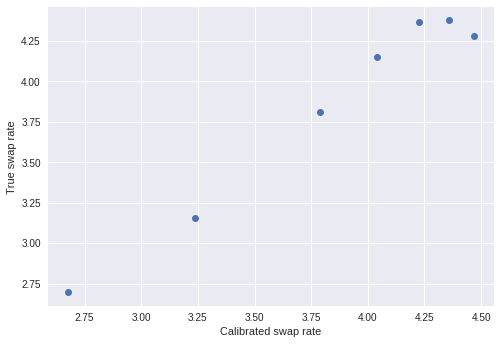

In [0]:
swap_2008_10_29 = [2.6967, 3.1557, 3.8111, 4.1497, 4.3638, 4.3753, 4.2772]
swap_maturities = [2, 3, 5, 7, 10, 15, 30]
swap_terms = [4, 6, 10, 14, 20, 30, 60]

x_var = np.zeros(len(swap_2008_10_29))

for i in range(len(x_var)):
  c_bond_price = zcb_price_explicit(swap_maturities[i], c_kappa_s, c_mu_s, c_sigma_s, c_r0_s)
  x_var[i] = swap_price_explicit(swap_maturities[i], swap_terms[i], c_kappa_s, c_mu_s, c_sigma_s, c_r0_s)

plt.plot(x_var,swap_2008_10_29,'o')
plt.xlabel('Calibrated swap rate')
plt.ylabel('True swap rate')

The downward curve in the last few points is concerning. This could be a side effect of using the same (possibly flawed) function used in the LIBOR calibration. Identify a better method and apply to both.